# COIN-TOLIMAN Simulations 2.0
---
Added complexites:
- More accurate spectra
- Jitter and telescope rotation
- Imperfect diffraction at non-ideal wavelengths

For these simulations we assume each 'image' is a congregation of 24 hors worth of frames. This allows us to clear our fundamental signal to noise ratio floor imposed by photon noise. Since Jitter and telescope rotation are not relevant at these time scales, we will simulate the jitter and rotation by imposing them on each 'image' as if it were a single frame captured by the CCD at \~10hz for jitter and some relevant time scale for rotation (\~minutes assuming a rotation period of 1 hour). The code will be written such that these paramters can be tweaked with ease to increase the accuracy of these simulation as more paramters are nailed down. 

In summary, each 'image' represents 24 hours worth of photons and science signal, and 1/10th of a second in terms of jitter and ~1 minute in terms of rotation.

In trying to increase the accuracy of these simulations to the final data set we will now try and confine our astrophysical paramters to closely represent the real world.

In [1]:
import sys
import os
dir_name = os.getcwd().split('/')[-1]
parent_path = os.getcwd()[:-(len(dir_name) + 1)]
sys.path.append(parent_path)

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import multiprocessing as mp
from astropy.io import fits
from scipy.ndimage import zoom
# from lib.FT_modelling import *
# from lib.formatter import * 
# from lib.conversions import *

In [92]:
specA = np.load("AcenA_cps_1.npy")
specB = np.load("AcenB_cps_1.npy")
wavels = np.load("Wavelengths.npy")
wavels = np.array(wavels, dtype=np.int)
natural_ratio = np.sum(specA)/np.sum(specB)

# Set flux ratio (total flux acenA / total flux acenB)
# To return to the astrophysical flux ratio set flux_ratio = natural_ratio 
diverse_spec = True # If True the two stars spectrums will not be identical
flux_ratio = natural_ratio

if diverse_spec:
    specB = specB*natural_ratio/flux_ratio
else:
    specB = specA/flux_ratio

Following on from our work in Rome we will impose a minimum of three cycles of science signal

In [54]:
# Telescope parameters
aperture = 0.1 # m
m2_obsc = 0 # m
focal_length = 3.65 # 15cm camera lens
npix = 256 # Only simulate central region to decrease computational complexity
pix_size = 6.5e-6 # 1.12 microns
transform_size = 2**10 # 1024 size of the transformed array

# Perfect PSF wavelength (ie 4 times mirror recession depth)
central_wavelength = 595e-9

In [55]:
# Science signal paramters
signal_size = 1e-6 # Pixels
signal_cycles = 1

# Astrophysical paramters
separation = 16.5 # Arceseconds
pix_sep = arcsec_to_pixel(separation, pix_size, focal_length)
pos_A = [0, 0] # Alpha cen A starting positon
pos_B = [pix_sep, 0] # Start with stars aligned along the x axis

# Simulation Paramters
# N = 1200 # Number of images
N = 10 # Number of images

# Random number seed
seed = 0
np.random.seed(seed)

# Jitter paramters
stdev = 0.5 # Pixels

# Rotation Parameters
n_rots = 0.5 # Number of rotations

In [56]:
# Camera parameters
dark_current = 80
read_noise = 1.3
QE = 0.95
full_well = 45e3
fps = 10

In [57]:
integration_time = 24 # Hours 
frame_rate = 10 # Hz

spd = 86400 # Seconds per day
fpd = spd*frame_rate # Frames per day

# Detector noise
dark_noise = read_noise + (dark_current/fps)

In [58]:
n_cores = 2

--- 
## Define x and y position arrays

Algorithm:
1. Generate science signal as a sinusoid centred around zero
2. Generate rotational signal and impose science signal on radius values
3. Convert to cartesian coordiantes
4. Generate jitters in cartesian coordiantes
5. Combine two sets of cartesian coordiantes

In [59]:
# Science signal
arg = np.linspace(0, signal_cycles*2*np.pi, num=N, endpoint=False)
drs = signal_size*np.sin(arg)

In [60]:
# Generate rotations
phis = np.linspace(0, n_rots*2*np.pi, num=N, endpoint=False)
Xs = np.vstack((pix_sep+drs) * np.cos(phis))
Ys = np.vstack((pix_sep+drs) * np.sin(phis))
coords = np.hstack((Xs, Ys))

In [61]:
# 2D Gaussian with a standard deviation of 0.5 pixels
jitters = np.random.normal(scale=stdev, size=2*N).reshape(N, 2)

In [62]:
A_coords_xy = jitters
B_coords_xy = coords + jitters

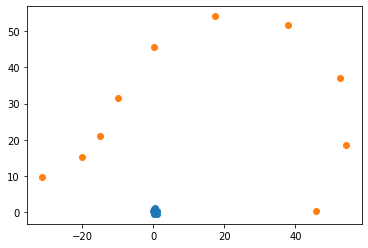

In [63]:
plt.scatter(A_coords_xy[:,0], A_coords_xy[:,1])
plt.scatter(B_coords_xy[:,0], B_coords_xy[:,1])

In [64]:
A_rs = (A_coords_xy[:,0]**2 + A_coords_xy[:,1]**2)**0.5
B_rs = (B_coords_xy[:,0]**2 + B_coords_xy[:,1]**2)**0.5

A_phis = np.arctan2(A_coords_xy[:,1], A_coords_xy[:,0])
B_phis = np.arctan2(B_coords_xy[:,1], B_coords_xy[:,0])

---
Pre-compute a series of pupils that will are pre-scaled to give the dersired FT array size for each wavelength

In [65]:
pupil_in = pupil_from_fits("pupil.fits")
sizes = []

for wl in wavels:
    # Caclaute how big the pupil array needs to be to get our desired Fourier Transformed array size
    plate_scale = pix_size/focal_length    # Radians per pixel
    spatial_freq = (wl*1e-9)/aperture
    scale_factor = spatial_freq/plate_scale
    size_out = int(transform_size/scale_factor)
    sizes.append([size_out, wl])

In [66]:
%%time
pool = mp.Pool(processes=n_cores)
null = pool.map(make_pupil, sizes)

CPU times: user 57.3 ms, sys: 36.2 ms, total: 93.5 ms
Wall time: 27.1 s


In [67]:
static = [aperture, m2_obsc, npix, focal_length, pix_size, transform_size]
combination_inputs = [specA, specB, fpd]
inputs = []

for n in range(N):
    for wl in wavels:
        for i in range(2):
            if i %2 == 0:
                r = A_rs[n]
                phi = A_phis[n]
                star = "A"
            else:
                r = B_rs[n]
                phi = B_phis[n]
                star = "B"
                
            dynamic = [n, wl, r, phi, star]
            inputs.append(static + dynamic)

In [68]:
%%time
pool = mp.Pool(processes=n_cores)
null = pool.map(model_image, inputs)

CPU times: user 188 ms, sys: 103 ms, total: 291 ms
Wall time: 1min 22s


In [81]:
# Combine images
for n in range(N):
    # Add detector noise
    im_out =  np.abs(np.round(np.random.normal(scale=dark_noise, size=[npix, npix])))
    
    for i in range(len(wavels)):
        wl = wavels[i]
        countsA = specA[i]
        countsB = specB[i]
                
        PSF_A = np.load("PSFs/{}_{}_A.npy".format(n, wl))
        PSF_B = np.load("PSFs/{}_{}_B.npy".format(n, wl))
        
        im_out += countsA*PSF_A + countsB*PSF_B
        
        
    np.save("images/{}.npy".format(n), im_out)

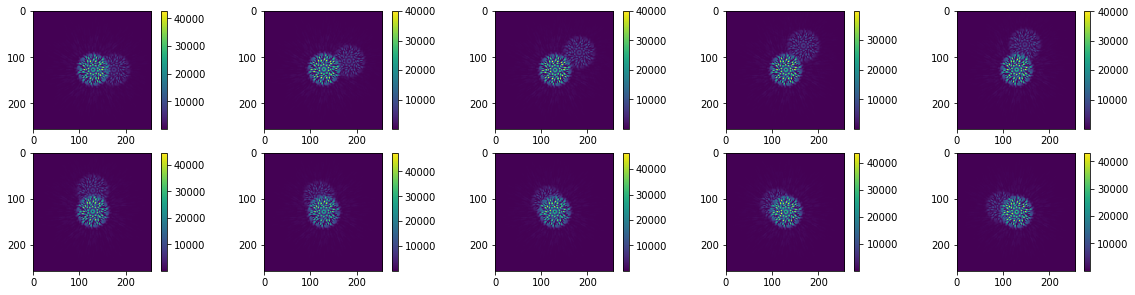

In [72]:
plt.figure(figsize=(20,10))

for i in range(N):
    plt.subplot(4, 5, i+1)
    plt.imshow(np.load("images/{}.npy".format(i)))
    plt.colorbar()
    
plt.show()

In [74]:
print(np.sum(np.load("images/{}.npy".format(0))))

65156992.0051083


In [82]:
print(np.sum(specA + specB))

64671819.00510828
